In [73]:
import os
print(os.getcwd())

train_val_test = {'train_fold.tsv':'Train', 'val_fold.tsv':'Val', 'test_fold.tsv':'Test'}

for segment, seg in train_val_test.items():
	with open(f'/work/contractors/jtaylor/acoustic_scene_classification/data/CochlScene/{segment}', 'w') as f:
		f.write('filename\tscene_label\n')

		directory = f'/work/contractors/jtaylor/acoustic_scene_classification/data/CochlScene/{seg}'
		for filename in os.listdir(directory):
			file_path = directory + '/' + filename
			for wav_file in os.listdir(file_path):
				# checking if it is a file
				f.write(f'{filename}/{wav_file}\t{filename}\n')


/mounts/ud3/contractors/jtaylor/acoustic_scene_classification/TwoStage/task1a/10class


## Using Cochlscene also requires some class mapping to the 10 DCASE classes

In [3]:
import os
import datetime
import time
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, log_loss
import soundfile as sound
import keras
import os
import scipy.io
import librosa
import pickle

from multiprocessing import Pool

from utils import *
from funcs import *

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

Using TensorFlow backend.
/work/user_data/jtaylor/home/.conda/envs/d20-keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/user_data/jtaylor/home/.conda/envs/d20-keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/user_data/jtaylor/home/.conda/envs/d20-keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

In [4]:
#Task 1a dev validation set, place to store features, and model path
file_path = '/work/contractors/jtaylor/acoustic_scene_classification/data/CochlScene/Val/'
csv_file = val_csv = '/work/contractors/jtaylor/acoustic_scene_classification/data/CochlScene/val_fold.tsv'
output_path = feat_path = '/work/contractors/jtaylor/acoustic_scene_classification/data/CochlScene/features/logmel128_scaled/'
#model_path = 'pretrained_models/10class-fcnn-model-0.7694.hdf5'
feature_type = 'logmel'


* DCASE2020 ASC audio clips have a fixed-length of 10 seconds.
* Log-mel filter bank (LMFB) features were used in our experiments as audio features. 
* The input audio waveform is analyzed with a 2048 SFFT points, a window size of 2048 samples, and a frameshift of 1024 samples.  
* The librosa [13] library is used to generate LMFBs, and the HTK formula definition for the Mel scale is adopted. 
* Due to different sampling rates for Tasks 1a and 1b, the final spectrogram has 431-time bins in Task 1a and 469-time bins in Task 1b, but the number of frequency bins is 128 in both
tasks. 
* Log-mel deltas and delta-deltas without padding were also
computed, which reduced the number of time samples to 423 for
Task 1a, and 461 for Tasks 1b. 
* The final input tensor size is thus 423 × 128 × 3 for Task 1a, and 461 × 128 × 6 for Task 1b. Before feeding the speech feature tensors into CNN classifier, we scaled each feature value into [0,1].


In [ ]:
# This code is from extr_feat_2020_nodelta_scaled.py
# This is just the feature extraction code. Will be saved and used during inference.

sr = 44100 # Sampling rate
duration = 10 # Windowing Size
num_freq_bin = 128 
num_fft = 2048 # Number of SFFT points & window size
hop_length = int(num_fft / 2) # Frameshift: SFFT computed every hop_length samples of the waveform
num_time_bin = int(np.ceil(duration * sr / hop_length)) # 10s * 44100 samps/sec divided by the shift window
num_channel = 1 # mono audio

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Evaluation fold information
data_df = pd.read_csv(csv_file, sep='\t', encoding='ASCII')
print(data_df.keys())
wavpath = data_df['filename'].tolist()
print(wavpath)

In [6]:
for i in range(len(wavpath)):

    # Returns the data and 
    stereo, fs = sound.read(file_path + wavpath[i], stop=duration*sr)
    
    # Create empty data structure with size of y (128 frequency bins) * x (431 time bins) * z (1 channel)
    logmel_data = np.zeros((num_freq_bin, num_time_bin, num_channel), 'float32')
    
    # Create spectrogram
    # Spectrogram returns 2D numpy array of size 128x431
    logmel_data[:,:,0]= librosa.feature.melspectrogram(stereo[:], sr=sr, n_fft=num_fft, hop_length=hop_length, n_mels=num_freq_bin, fmin=0.0, fmax=sr/2, htk=True, norm=None)
    logmel_data = np.log(logmel_data+1e-8) #Got mel spectrogram, now log it.
    
    # Some sort of rescaling but tbh I'm not sure whats going on
    feat_data = logmel_data
    feat_data = (feat_data - np.min(feat_data)) / (np.max(feat_data) - np.min(feat_data))
    feature_data = {'feat_data': feat_data,}

    # Write to pickle file
    cur_file_name = output_path + os.path.basename(wavpath[i])[:-3] + feature_type
    pickle.dump(feature_data, open(cur_file_name, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

## Start of the Inference Notebook

In [9]:
base_path = '/work/user_data/jtaylor/data/acoustic_scene_classification'
file_path = f'{base_path}/data/CochlScene/Val/'
csv_file = val_csv = f'{base_path}/data/CochlScene/val_shuffled_tiny.tsv'
output_path = feat_path = f'{base_path}/data/CochlScene/features/logmel128_scaled/'

model_path = 'fcnn/cochlscene/model-250-0.7619.hdf5'
feature_type = 'logmel'

In [10]:
dev_test_df = pd.read_csv(val_csv,sep='\t', encoding='ASCII')
wav_paths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])
print(ClassNames)

['Bus' 'Cafe' 'Car' 'CrowdedIndoor' 'Elevator' 'Kitchen' 'Park'
 'ResidentialArea' 'Restaurant' 'Restroom' 'Street' 'Subway'
 'SubwayStation']


In [11]:
for idx, elem in enumerate(wav_paths):
    wav_paths[idx] = wav_paths[idx].split('/')[-1].split('.')[0]
    wav_paths[idx] = wav_paths[idx].split('-')[-1]

num_freq_bin = 128
num_classes = 13

# get results for each device
data_val, y_val = load_data_2020(feat_path, val_csv, num_freq_bin, 'logmel')
data_deltas_val = deltas(data_val)
data_deltas_deltas_val = deltas(data_deltas_val)
data_val = np.concatenate((data_val[:,:,4:-4,:],data_deltas_val[:,:,2:-2,:],data_deltas_deltas_val),axis=-1)
y_val_onehot = keras.utils.np_utils.to_categorical(y_val, num_classes)

In [7]:
best_model = keras.models.load_model(model_path)








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
output = best_model.predict(data_val, batch_size=10)

InternalError: 2 root error(s) found.
  (0) Internal: cuDNN launch failure : input shape ([10,3,128,423])
	 [[{{node batch_normalization_89/cond/FusedBatchNorm}}]]
	 [[activation_99/Softmax/_679]]
  (1) Internal: cuDNN launch failure : input shape ([10,3,128,423])
	 [[{{node batch_normalization_89/cond/FusedBatchNorm}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
y_pred_val = np.argmax(output,axis=1)

[ 5  5  5  8  4  6  3  9  5  7  6  8 12 10  2 10  0  9  7  9  2  1 12  9
 10  2  4 12  2  1 10 10 10 11  4 12  6  0  8 12  3  5  8  7  7  7 10 11
 11 12 11 11  5  9  8  6  9 10  4  4  4  9 12  8  7 11  1  5  6  4  4  2
  9  8 11 11 10  0  0  1 12 10  8  9 10  4 10  8  7 10  1  4  6  3  2  7
  0  4  8  2  2  8  4  9 12  8 10  4  3  0  0  0  3  1  4  4  8  7 12  2
  4 11  8  8  2 11  0 12  7 11  9  4  7 11  4  7  5  8 10 11  1  0  0  1
 10  8 11  5 11  9  0  4  1  1  1  5 11  5  5  8  6  7 11 11  1  1  4  0
  6  6  8 12  8  1 10  3  6 11 12  2  8 12  1  0  1  9  6 11  6 12  8  2
  5  1  1  2 12 12  5  5  9  1  0  4  8  2  3 10  4  9  0 12 10  2 12  5
 10  7  0 11  6  4  1 12  7  2  0  1  8  5 10]


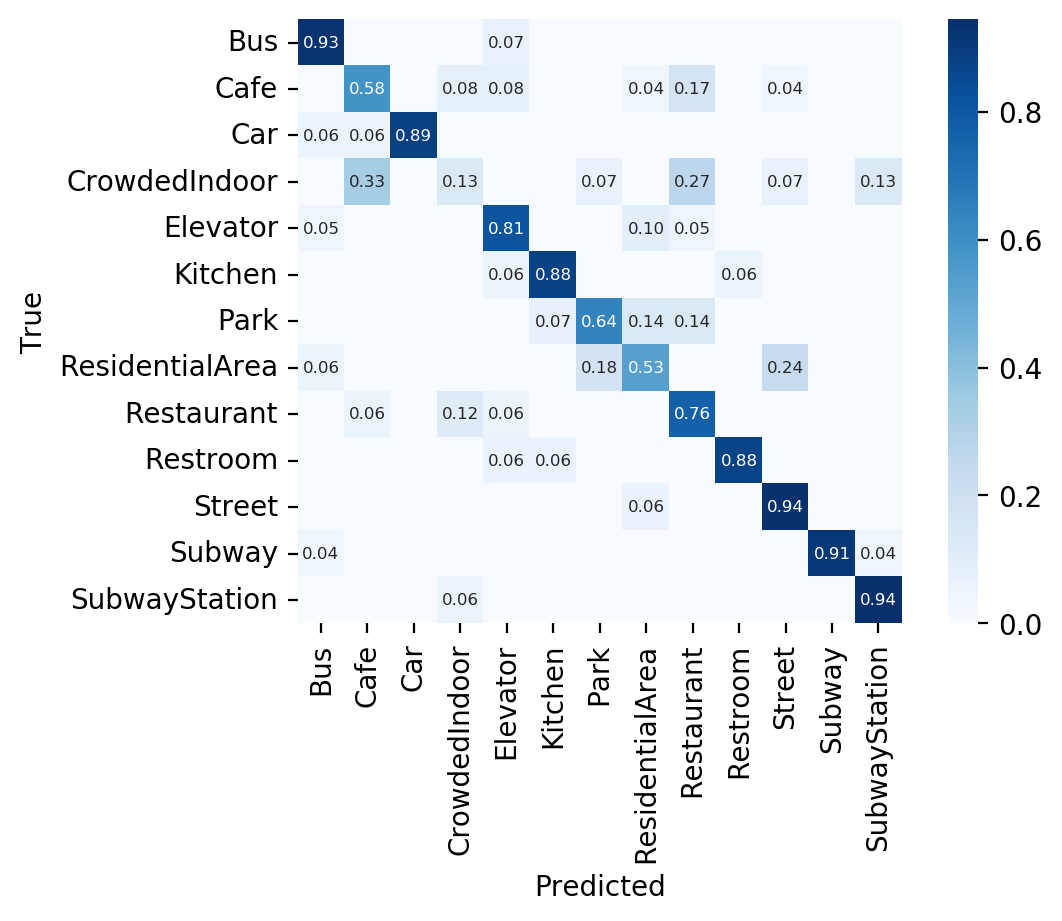

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# get confusion matrix
conf_matrix = confusion_matrix(y_val,y_pred_val)

print(conf_matrix)
#conf_matrix = np.delete(conf_matrix, np.s_[0:], axis=1)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=ClassNames, yticklabels=ClassNames, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()

## CLASS MAPPING MUMBO JUMBO

In [16]:

print(y_pred_val)
print(len(y_pred_val))
DCASE_ClassNames = ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square',
 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']
print(DCASE_ClassNames)


# Predicted bus as bus, cafe as shopping mall, and car as travelling by metro

[8 8 8 ... 6 3 9]
7687
['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square', 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']


In [ ]:
print(y_val)
print(ClassNames)
print(DCASE_ClassNames)

mapping_dict = {
	'Bus':'bus',
	'Cafe':'airport',
	'Car':'tram',
	'CrowdedIndoor':'shopping_mall',
	'Elevator':'airport',
	'Kitchen':'airport',
	'Park':'park',
	'ResidentialArea':'street_pedestrian',
	'Restaurant':'airport',
	'Restroom':'airport',
	'Street':'street_traffic',
	'Subway':'metro',
	'SubwayStation':'metro_station'
}

y_val_mapped = [DCASE_ClassNames.index(mapping_dict[ClassNames[y_label]]) for y_label in y_val]
print(y_val_mapped)

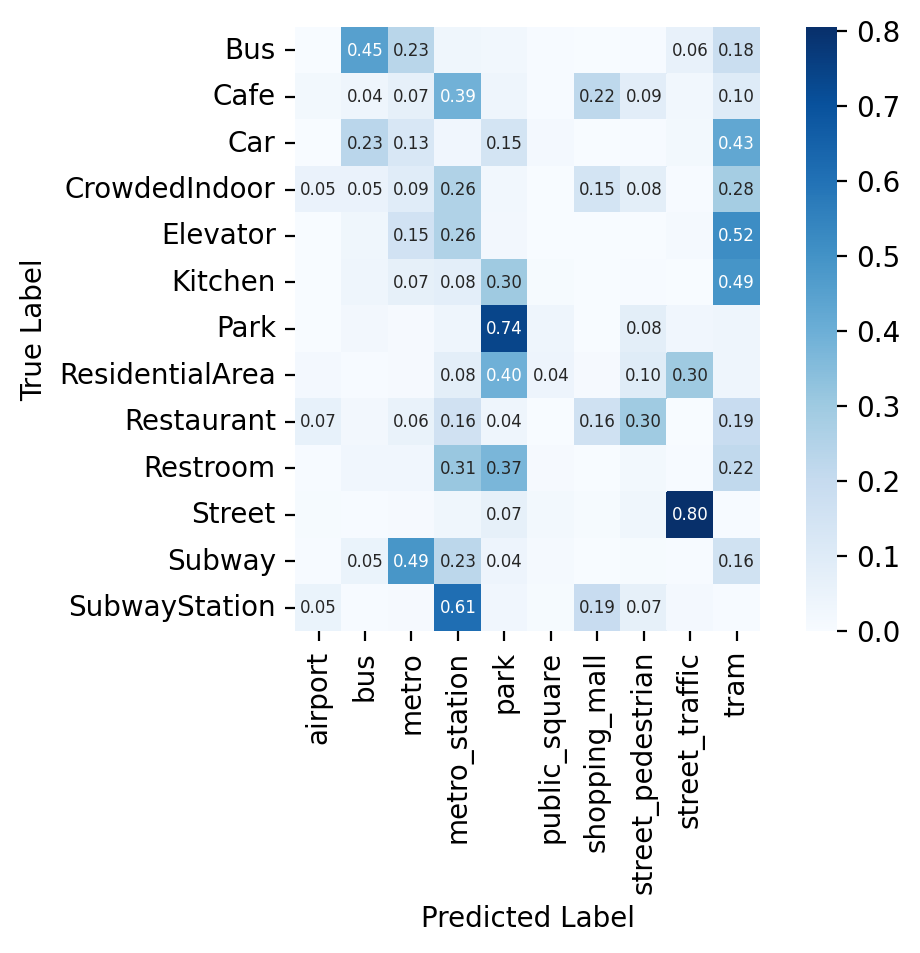

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# get confusion matrix
conf_matrix = confusion_matrix(y_val,y_pred_val)
conf_matrix = np.delete(conf_matrix, np.s_[-3:], axis=1)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=DCASE_ClassNames, yticklabels=ClassNames, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('DCASE Predicted Class')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('CochlScene Classes')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()

/work/contractors/jtaylor/.conda/envs/d20-keras/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/work/contractors/jtaylor/.conda/envs/d20-keras/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


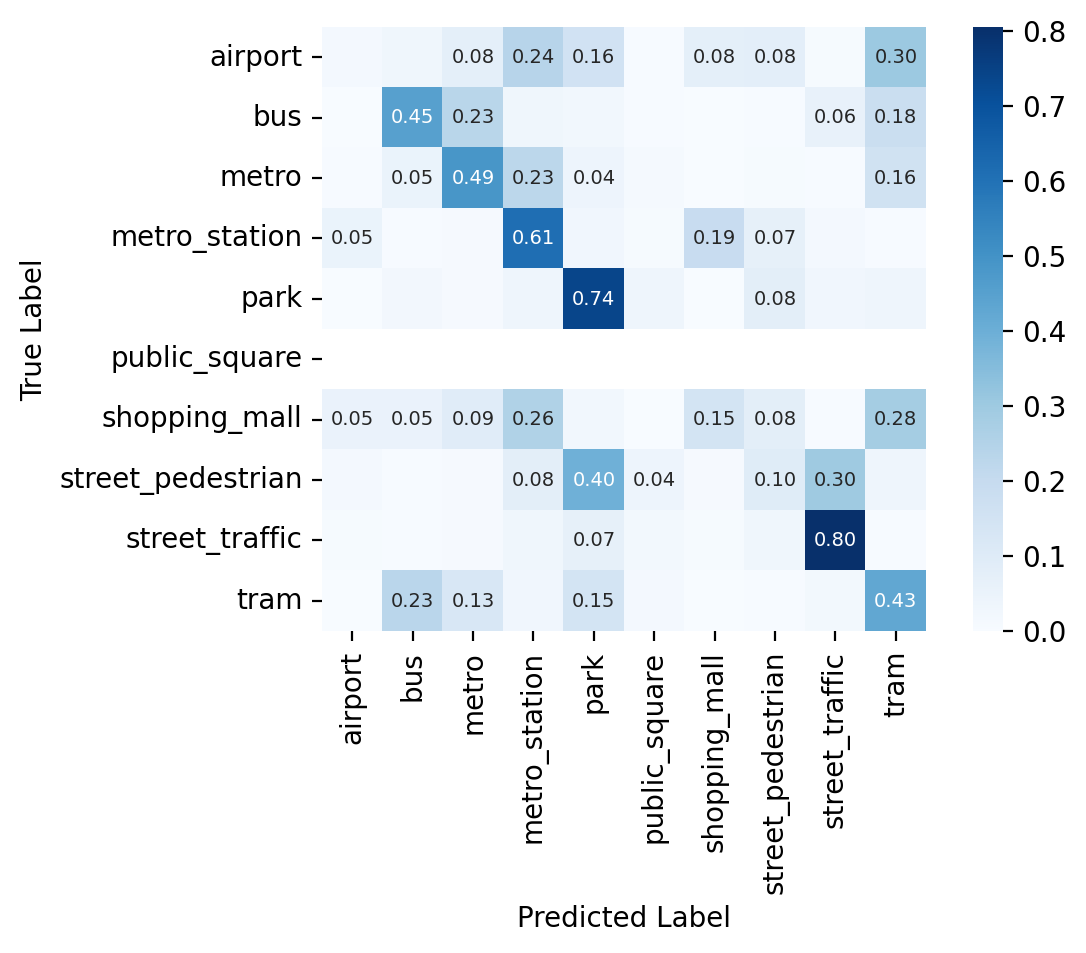

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# get confusion matrix
conf_matrix = confusion_matrix(y_val_mapped,y_pred_val)

conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 7}
ax = sns.heatmap(percentages, xticklabels=DCASE_ClassNames, yticklabels=DCASE_ClassNames, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()